In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib notebook

In [2]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

In [3]:
with open('/home/dlandry/ssdataset/validation/2018-05-23-haupt-cross-val/summary.csv') as f:
    df = pd.read_csv(f)

In [4]:
df

,location,reading,reference,loss,kullback_leibler
0,stairs,1,0,0.893637,38.206943
1,stairs,2,0,0.847119,27.155136
2,stairs,2,1,0.941834,39.321490
3,stairs,3,0,0.914622,28.049152
4,stairs,3,1,0.942222,22.133326
5,stairs,3,2,0.986978,29.522832
6,stairs,4,0,0.881473,12.967232
7,stairs,4,1,1.047584,16.419330
8,stairs,4,2,1.271002,18.662267
9,stairs,4,3,1.280265,17.129960


<IPython.core.display.Javascript object>


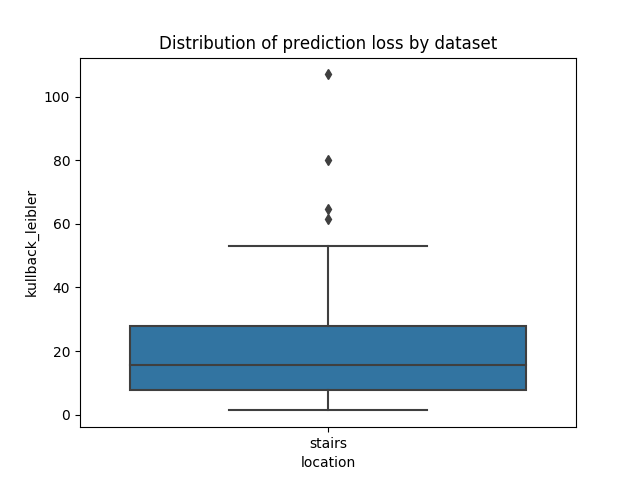

In [6]:
sb.boxplot(x=df['location'], y=df['kullback_leibler'])
plt.title('Distribution of prediction loss by dataset')

In [7]:
df[df['location'] == 'plain']

,location,reading,reference,loss,kullback_leibler


# Similarity matrix between descriptors

In [56]:
import json
import matplotlib.ticker as ticker
import numpy as np
import torch
import seaborn as sb

from recova.learning.learning import model_loader

# Big kickass matrix

In [19]:
dataset_names = [
    'apartment',
    'gazebo-summer',
    'gazebo-winter',
    'plain',
    'stairs',
    'wood-autumn',
    'wood-summer'
]

with open('/home/dlandry/ssdataset/learning_sets/2018-05-23-normals-444-nohaupt.json') as f:
    learning_dataset = json.load(f)
    xs = np.array(learning_dataset['data']['xs'])
    ys = np.array(learning_dataset['data']['ys'])

learning_runs = {}
for d in dataset_names:
    learning_run_file = '/home/dlandry/ssdataset/learning_runs/2018-05-23-normals-444-nohaupt-val-{}.json'.format(d)
    
    
    with open(learning_run_file) as f:
        learning_run = json.load(f)
        learning_runs[d] = learning_run

In [23]:
example_learning_run = learning_runs[dataset_names[0]]
n = len(example_learning_run['train_set']) + len(example_learning_run['validation_set'])
similarity_matrix = np.zeros((n, n))
no_data_mask = np.zeros((n,n), dtype=np.bool)

col = 0
for d in dataset_names:
    learning_run = learning_runs[d]
    model = model_loader(learning_run)
    
    no_data_mask[learning_run['validation_set'], col:len(learning_run['validation_set'])]
    
    for pair in learning_run['validation_set']:
        distances = model.compute_distances(xs[pair])
        weights = model.distances_to_weights(torch.Tensor(distances))
        
        similarity_matrix[learning_run['train_set'],col] = weights
        no_data_mask[learning_run['validation_set'],col] = True
        col += 1
    

In [88]:
labels = []
major_ticks = []

last_pos = 0
for d in dataset_names:
    labels.append(d)
    major_ticks.append(last_pos - 1)
    
    last_pos += len(learning_runs[d]['validation_set'])
major_ticks.append(last_pos-1)


minor_ticks = []
for i in range(len(major_ticks) - 1):
    minor_ticks.append((major_ticks[i] + major_ticks[i+1]) / 2.)
    
print(minor_ticks)
print(major_ticks)
print(labels)

[84.0, 228.0, 344.0, 458.0, 572.0, 688.0, 816.0]
[-1, 169, 287, 401, 515, 629, 747, 885]
['apartment', 'gazebo-summer', 'gazebo-winter', 'plain', 'stairs', 'wood-autumn', 'wood-summer']


<IPython.core.display.Javascript object>


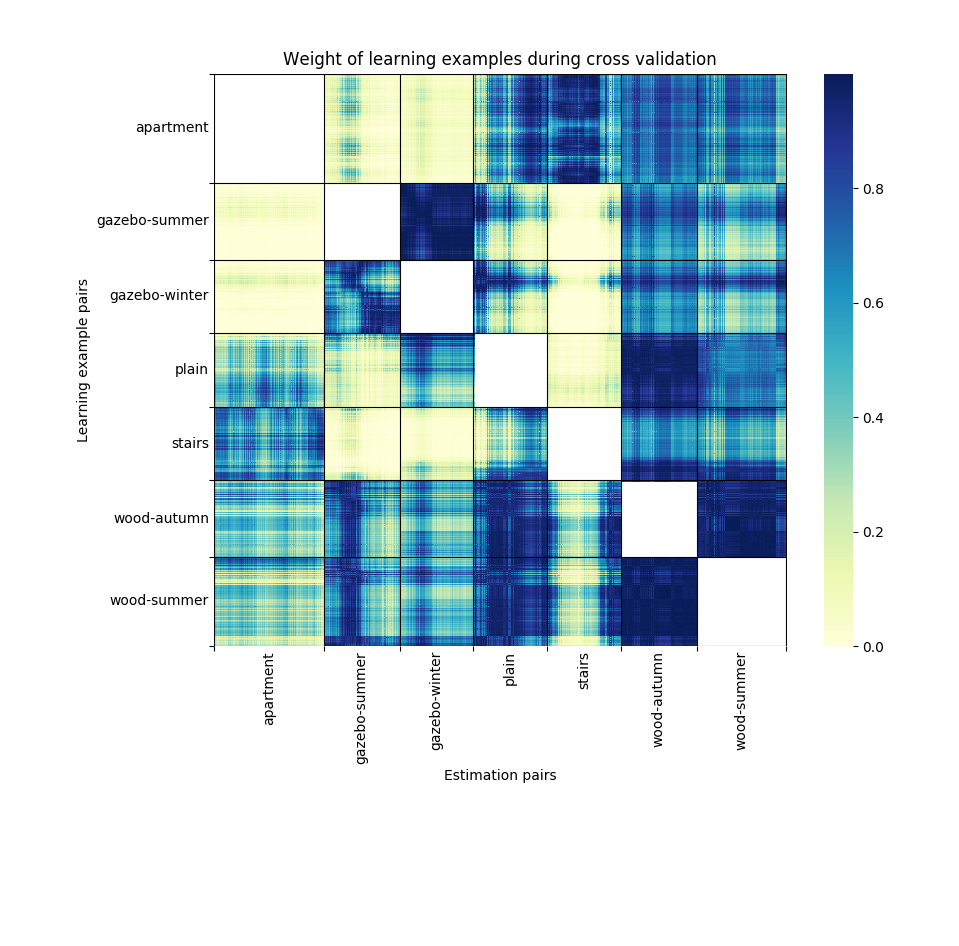

In [93]:
fig, ax = plt.subplots()
sb.heatmap(similarity_matrix, mask=no_data_mask, ax=ax, square=True, cmap='YlGnBu')

ax.set_xticks(major_ticks)
ax.set_xticklabels('')
ax.set_xticks(minor_ticks, minor=True)
ax.set_xticklabels(labels, horizontalalignment='center', minor=True, rotation=90)

ax.set_yticks(major_ticks)
ax.set_yticklabels('')
ax.set_yticks(minor_ticks, minor=True)
ax.set_yticklabels(labels, verticalalignment='center', minor=True)

ax.set_xlabel('Estimation pairs')
ax.set_ylabel('Learning example pairs')
ax.set_title('Weight of learning examples during cross validation')

ax.grid(color='black')
ax.tick_params(axis='both', which='minor', length=0)
plt.tight_layout()

# For husky queries

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sb

from recova.learning.learning import model_loader

In [3]:
with open('/home/dlandry/dataset/learning_sets/2018-06-05-planarity.json') as f:
    learning_dataset = json.load(f)
    xs = np.array(learning_dataset['data']['xs'])
    ys = np.array(learning_dataset['data']['ys'])

with open('/home/dlandry/dataset/query_sets/2018-06-05-planarity.json') as f:
    query_dataset = json.load(f)
    xs_query = np.array(query_dataset['data']['xs'])
    
with open('/home/dlandry/dataset/learning_runs/2018-06-06-planarity.json.json') as f:
    learning_run = json.load(f)
    model = model_loader(learning_run)

In [4]:
learning_run['validation_set']

similarity_matrix = np.zeros((len(learning_run['train_set']), len(xs_query)))
optimization_set = learning_run['train_set']

sort_of_examples = np.argsort(learning_run['train_set'])
train_set = np.array(learning_run['train_set'])

for q in range(len(xs_query)):
    distances = model.compute_distances(xs_query[q])
    weights = model.distances_to_weights(torch.Tensor(distances))
   
    similarity_matrix[:, q] = weights[sort_of_examples]


In [5]:
#no_data_mask = np.zeros((len(learning_dataset['data']['pairs']), len(xs_query)))
#no_data_mask[learning_run['validation_set'], :] = 1

print(learning_run['validation_set'])

[536, 739, 212, 460, 271, 173, 200, 606, 408, 743, 505, 482, 159, 671, 481, 626, 389, 623, 280, 764, 263, 514, 847, 621, 428, 323, 311, 320, 14, 878, 349, 210, 401, 682, 477, 326, 236, 883, 715, 608, 613, 394, 525, 259, 855, 441, 843, 183, 648, 313, 532, 61, 46, 416, 82, 748, 447, 16, 67, 78, 537, 854, 305, 392, 794, 549, 691, 522, 685, 584, 792, 729, 239, 107, 165, 111, 868, 538, 378, 411, 713, 88, 325, 58, 603, 719, 370, 308, 240, 255, 455, 413, 746, 833, 852, 699, 254, 762, 665, 310, 150, 588, 472, 801, 695, 622, 278, 114, 504, 372, 735, 802, 687, 795, 506, 840, 348, 471, 579, 69, 184, 425, 253, 676, 567, 830, 634, 443, 513, 789, 866, 369, 510, 652, 582, 598, 324, 295, 287, 696, 494, 269, 225, 27, 850, 298, 50, 646, 497, 257, 758, 627, 784, 122, 106, 483, 737, 479, 343, 552, 434, 157, 119, 783, 640, 722, 153, 577, 104, 531, 480, 306, 55, 262, 330, 248, 152, 841, 149, 59, 205, 492, 774, 674, 129, 437, 363, 600, 309, 556, 744, 328, 81, 181, 863, 144, 771, 649, 456, 773, 126, 629, 558,

In [6]:

dataset_names = [
    'apartment',
    'gazebo-summer',
    'gazebo-winter',
    'plain',
    'stairs',
    'wood-autumn',
    'wood-summer'
]

dataset_counts = {}
for index in sorted(learning_run['train_set']):
    pair = learning_dataset['data']['pairs'][index]
    
    if  pair['dataset'] not in dataset_counts:
        dataset_counts[pair['dataset']] = 1
    else:
        dataset_counts[pair['dataset']] += 1

labels = []
major_ticks = []
last_pos = 0
for d in sorted(dataset_counts):
    labels.append(d)
    major_ticks.append(last_pos - 1)
    
    last_pos += dataset_counts[d]
major_ticks.append(last_pos-1)


minor_ticks = []
for i in range(len(major_ticks) - 1):
    minor_ticks.append((major_ticks[i] + major_ticks[i+1]) / 2.)
    
print(minor_ticks)
print(major_ticks)
print(labels)

query_major_ticks = [0, len(query_dataset['data']['pairs'])]
query_minor_ticks = [len(query_dataset['data']['pairs']) / 2.]
query_labels = ['grand-axe']

[63.0, 170.5, 251.0, 332.0, 415.5, 494.5, 575.5, 618.0]
[-1, 127, 214, 288, 376, 455, 534, 617, 619]
['apartment', 'gazebo_summer', 'gazebo_winter', 'hauptgebaude', 'plain', 'stairs', 'wood_autumn', 'wood_summer']


In [7]:
fig, ax = plt.subplots()
sb.heatmap(similarity_matrix, ax=ax, square=True, cbar_kws={"shrink": .82})
ax.tick_params(axis='both', which='minor', length=0)



#ax.set_xticks(query_major_ticks)
#ax.set_xticklabels('')
#ax.set_xticks(query_minor_ticks, minor=True)
#ax.set_xticklabels(query_labels, horizontalalignment='center', minor=True, rotation=90)



ax.set_yticks(major_ticks)
ax.set_yticklabels('')
ax.set_yticks(minor_ticks, minor=True)
ax.set_yticklabels(labels, verticalalignment='center', minor=True)

ax.set_xlabel('Estimation pairs')
ax.set_ylabel('Learning example pairs')
ax.set_title('Weight of learning examples during cross validation')


plt.tight_layout()

In [8]:
fig.set_size_inches((40.0,10.0))
plt.savefig('/home/dlandry/fig.png')

# Regular everyday matrix

In [ ]:


with open('/home/dlandry/ssdataset/learning_runs/2018-05-23-normals-444-nohaupt-val-gazebo-winter.json') as f:
    learning_run = json.load(f)
model = model_loader(learning_run)

In [ ]:
dataset_xs = np.array(dataset['data']['xs'])

xs = dataset_xs[learning_run['validation_set']]

In [ ]:
weights = np.empty((len(xs), len(model.model_predictors)))

for i, descriptor in enumerate(xs):
    dists = model.compute_distances(descriptor)
    weights[i] = model.distances_to_weights(torch.Tensor(dists))

In [ ]:
# Reorder by dataset
list_of_locations = np.array([x['dataset'] for x in dataset['data']['pairs']])

In [ ]:
list_of_locations[learning_run['train_set']]

In [ ]:
def add_dataset_boundaries(location_list, ax):
    preceding_location = ''
    for i, location in enumerate(location_list):
        if location != preceding_location:
            ax.hlines(y=i, xmin=0, xmax=100)
            plt.text(5, i + 25, location)
        preceding_location = location

In [ ]:
fig, ax = plt.subplots()

im = ax.imshow(weights.T)
cbar = plt.colorbar(im)
cbar.ax.set_ylabel('Weight')
plt.xlabel('Example ID (training set)')
plt.ylabel('Example ID (validation set)')
plt.title('Weight of the training examples during \n the validation of apartment')

test_locations = list_of_locations[learning_run['train_set']]
add_dataset_boundaries(test_locations, ax)


plt.show()

In [ ]:
# Find the boundaries in datasets


In [ ]:
learning_run['train_set']